In [1]:
# Dataset taken from https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.metrics import error_rate
import numpy as np

In [4]:
torch.cuda.set_device(0)

In [5]:
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

In [6]:
path = Path('../input/cell_images/cell_images'); path

PosixPath('../input/cell_images/cell_images')

In [7]:
path.ls()

[PosixPath('../input/cell_images/cell_images/Uninfected'),
 PosixPath('../input/cell_images/cell_images/Parasitized')]

# Data Exploration

In [8]:
import os

In [9]:
np.random.seed(42)

In [10]:
path_image_parasitized = Path('../input/cell_images/cell_images/Parasitized/')
path_image_uninfected = Path('../input/cell_images/cell_images/Uninfected/')

In [11]:
parasitized_images = get_image_files(path_image_parasitized)[:10]
parasitized_images

[PosixPath('../input/cell_images/cell_images/Parasitized/C99P60ThinF_IMG_20150918_141620_cell_36.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C118P79ThinF_IMG_20151002_105827_cell_130.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C137P98ThinF_IMG_20151005_163712_cell_85.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C124P85ThinF_IMG_20151002_153825_cell_190.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C93P54ThinF_IMG_20150821_163640_cell_196.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C68P29N_ThinF_IMG_20150819_133350_cell_183.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C39P4thinF_original_IMG_20150622_112119_cell_21.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C133P94ThinF_IMG_20151004_154351_cell_106.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C182P143NThinF_IMG_20151201_172257_cell_163.png'),
 PosixPath('../input/cell_images/cell_ima

In [12]:
path_para, dirs, files = next(os.walk(path_image_parasitized))
file_count = len(files)
print("Number of images for parasitized:", file_count)

Number of images for parasitized: 13780


torch.Size([118, 202])

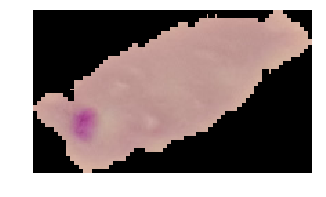

In [13]:
images_para = open_image(parasitized_images[np.random.randint(0, 9)])
images_para.show(figsize=(5,5))
images_para.size

In [14]:
uninfected_images = get_image_files(path_image_uninfected)[:10]
uninfected_images

[PosixPath('../input/cell_images/cell_images/Uninfected/C241NThinF_IMG_20151207_124643_cell_125.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C211ThinF_IMG_20151029_164248_cell_207.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C76P37ThinF_IMG_20150815_172808_cell_170.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C226ThinF_IMG_20151112_131546_cell_172.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C187P148NThinF_IMG_20151203_153036_cell_98.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C65P26N_ThinF_IMG_20150818_154624_cell_41.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C240ThinF_IMG_20151127_115306_cell_6.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C183P144NThinF_IMG_20151201_224458_cell_31.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C180P141NThinF_IMG_20151201_165601_cell_39.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C230ThinF_

In [15]:
path_unin, dirs, files = next(os.walk(path_image_uninfected))
file_count = len(files)
print("Number of images for uninfected:", file_count)

Number of images for uninfected: 13780


torch.Size([121, 139])

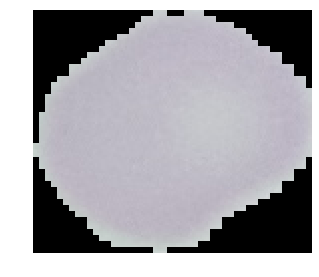

In [16]:
images_unin = open_image(uninfected_images[np.random.randint(0, 9)])
images_unin.show(figsize=(5,5))
images_unin.size

## Observations: 
- Data is evenly balanced in number of images for uninfected and infected
- Images aren't evenly sized.
- I assume purple cells are white blood cells and peach are red blood cells
- Not positive on what ThinF means. I assume it means thin slices of cells
- Unsure what the various versions of ReThinF, NThinF, ThinF, thinF, etc. denotes in the images


# Data Bunching
<input type="checkbox"> Combine uninfected & infected for training set
<input type="checkbox"> Resize images to uniform size


In [17]:
path

PosixPath('../input/cell_images/cell_images')

In [18]:
data = ImageDataBunch.from_folder(path, train=".",
                                  valid_pct=0.2, # Splits the dataset into 80/20% training/validation
                                  ds_tfms=get_transforms(do_flip = True, flip_vert = True, max_warp=0), # AFAIK images can be flipped any direction vertically, horizontally, 90 degrees in actual cell images
                                  size=256,bs=16 # Trying out a larger 256 size at first
                                 ).normalize(imagenet_stats)

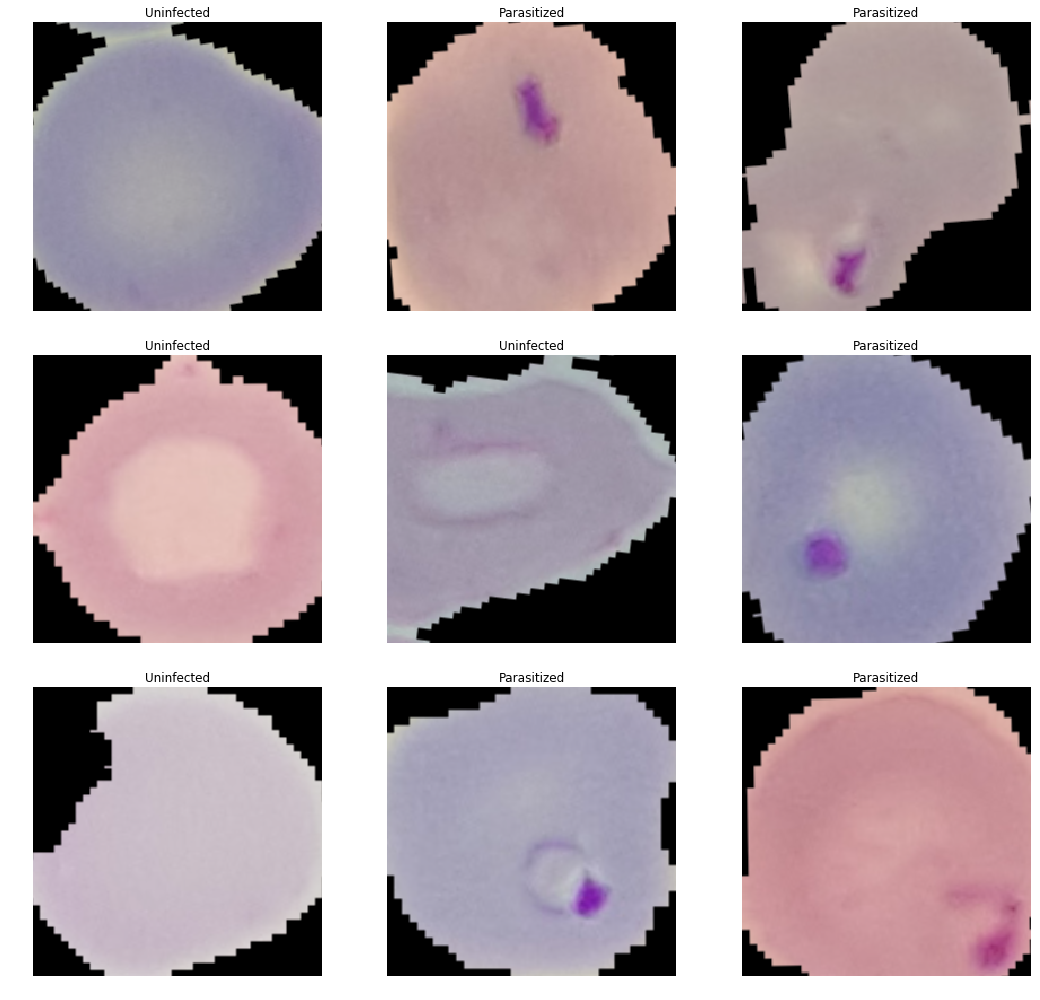

In [19]:
data.show_batch(rows=3, figsize=(15,14))

In [20]:
print(data.classes)
len(data.classes),data.c

['Parasitized', 'Uninfected']


(2, 2)

# Model Training

In [21]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, model_dir="/kaggle/model")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 104396119.62it/s]


In [22]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [23]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.211275,0.133267,0.047904,03:33
1,0.163780,0.123828,0.043549,03:19
2,0.174245,0.110610,0.039013,03:20
3,0.163693,0.113145,0.038650,03:16


In [24]:
learn.save('malaria_initial_training')

# Examining results of initial training

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

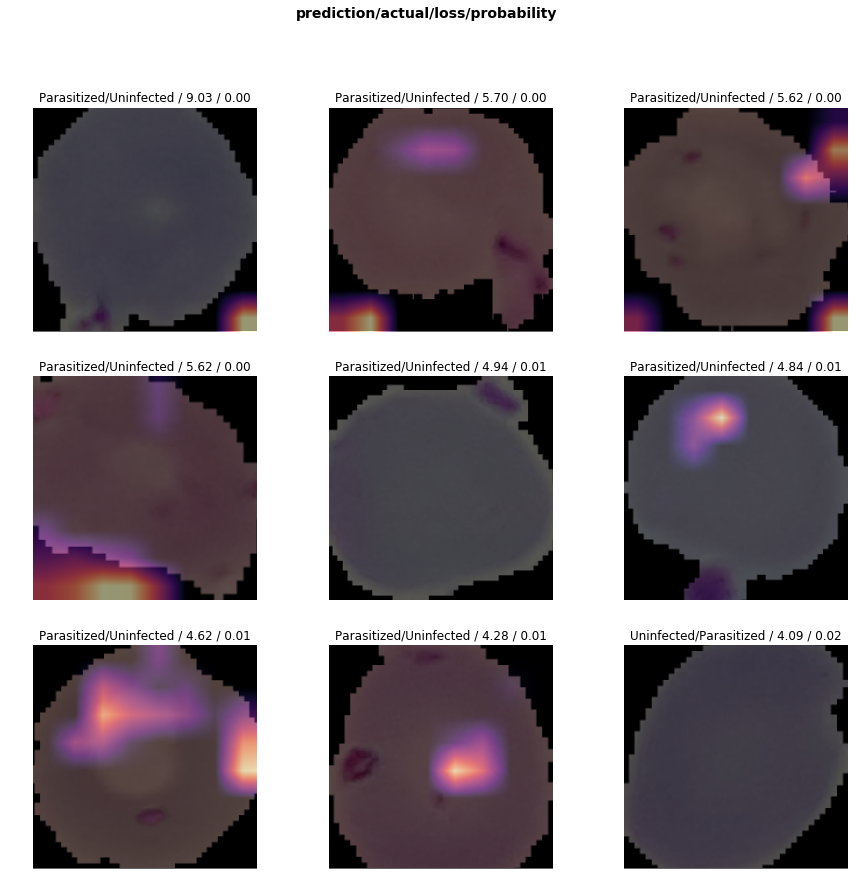

In [26]:
# Note: these are images that are in the top_losses section. Model was not sure what these were 
# TODO: Ask someone with biology background to predict these
interp.plot_top_losses(9, figsize=(15,14))

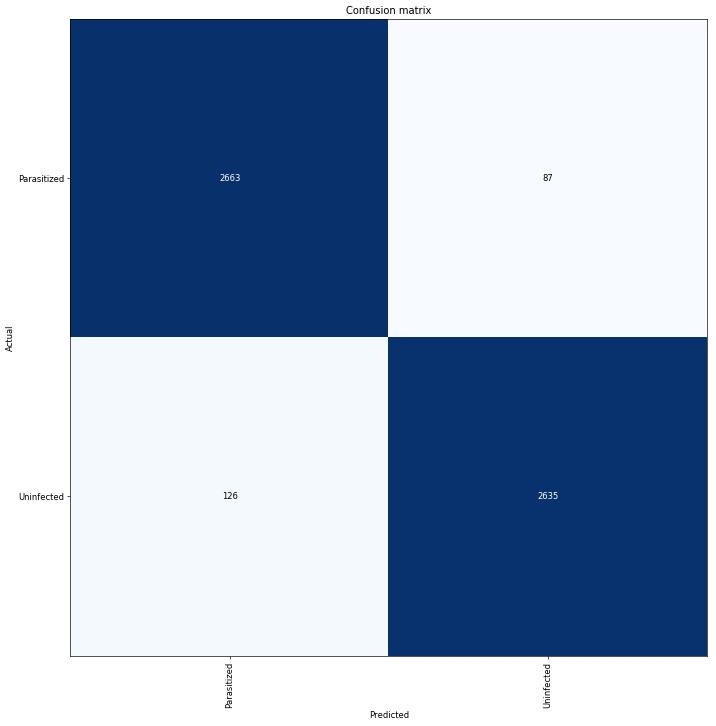

In [27]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Model improvement
<input type="checkbox"> Unfreeze layer 1. All the information gleamed off resnet34 to form basic shapes as I understand it.
<input type="checkbox"> Fine tune learning rate

In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.152432,0.155589,0.040827,03:21


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


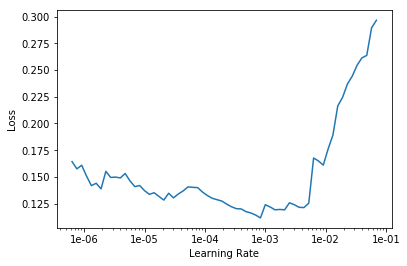

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.150559,0.108747,0.038469,03:21
1,0.136587,0.102920,0.036473,03:22


# Reexamining results
Improvement! 🙌

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

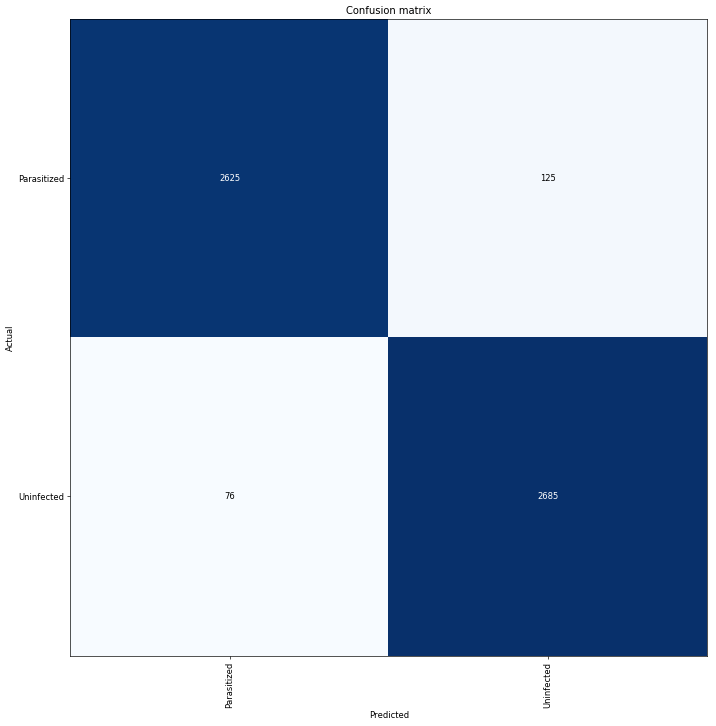

In [33]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [34]:
learn.save('malaria_unfrozen_and_tuned')

# But 97% accuracy is probably too low for medical diagnosis. I'm guessing they want 99.9% or higher
> <input type="checkbox"> ResNet50

In [35]:
# learn.load('malaria_unfrozen_and_tuned')

In [36]:
data = ImageDataBunch.from_folder(path, train=".",
                                  valid_pct=0.2, # Splits the dataset into 80/20% training/validation
                                  ds_tfms=get_transforms(do_flip = True, flip_vert = True, max_warp=0), # AFAIK images can be flipped any direction vertically, horizontally, 90 degrees in actual cell images
                                  size=299,bs=8
                                 ).normalize(imagenet_stats)

In [37]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, model_dir="/kaggle/model")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.torch/models/resnet50-19c8e357.pth
102502400it [00:00, 104763442.87it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


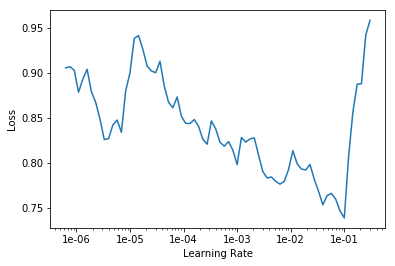

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.218502,0.149339,0.052259,04:57
1,0.225478,0.133365,0.041735,04:55
2,0.209664,0.173351,0.043005,04:53
3,0.167606,0.137447,0.047723,04:54
4,0.165563,0.110484,0.038287,04:54
5,0.169536,0.347057,0.039739,04:54
6,0.180157,0.133972,0.036654,04:54
7,0.121427,0.109996,0.034658,04:54


In [40]:
learn.save('malaria_initial_training_resnet50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


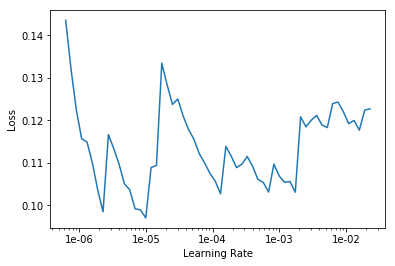

In [43]:
learn.lr_find()
learn.recorder.plot()

In [42]:
#TODO: Figure out why ResNet50 didn't result in higher accuracy